In [429]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path="dataset/models/"
scenes_path="dataset/scenes/"

products_B={i:f"{models_path}ref{i}.png" for i in range(15,28)}

scenes_B={i:f"{scenes_path}scene{i}.png" for i in range(6,13)}

In [471]:
img_shapes = {
    6: (1072, 1514),
    7: (766, 1146),
    8: (1014, 1504),
    9: (662, 1488),
    10: (932, 1696),
    11: (674, 1482),
    12: (704, 1626),
}

positions = {
    8: {
        'c': [10, 450, 820, 1160, img_shapes[8][1]],
        'r': [180, img_shapes[8][0]]
    },
    9: {
        'c': [0, 230, 490, 730, 970, 1230, 1470],
        'r': [150, img_shapes[9][0]]
    },
    10: {
        'c': [580, 840, 1120, 1390, 1650],
        'r': [200, 850]
    },
    11: {
        'c': [70, 255, 450, 650, 840, 1035, 1240, 1440],
        'r': [120, 620]
    },
    12: {
        'c': [0, 280, 560, 815, 1080, 1350, 1610],
        'r': [150, 150+570]
    },
}
positions2 = {
    12: {
        'c': [(4, 232),(320, 548),(563,807), (843, 1087),(1110, 1354),(1349, 1593)],
        'r': [(124,704),(122,702),(57,57+606),(19,19+606),(39,39+606),(31,31+606)]
    },
}

checks = {
    8: {
        0:[18,26,27],1:[17,23,24],2:[17,23,24],3:[17,23,24]
    },
    9: {
        0:[18,20,26,27],1:[18,20,26,27],2:[18,19,26,27],3:[18,19,26,27],4:[20],5:[20]
    },
    10: {
        0: [21,22,23], 1: [21,22,23], 2: [21,22,23], 3: [21,22,23]
    },
    11: {
        0: [17,23,24], 1: [17,23,24], 2: [17,23,24], 3: [17,23,24],4:[25],5:[25],6:[25]
    },
    12: {
        0:[18,26,27],1:[18,26,27],2:[18,26,27],3:[18,26,27],4:[18,26,27],5:[18,26,27]
    },
}

true = {
    8: {
        0: 27, 1: 23, 2: 23, 3: 24
    },
    9: {
        0: 18, 1: 18, 2: 19, 3: 19, 4: 20, 5: 20
    },
    10: {
        0: 21, 1: 21, 2: 22, 3: 22
    },
    11: {
        0: 23, 1: 23, 2: 24, 3: 24, 4: 25, 5: 25, 6: 25
    },
    12: {
        0: 26, 1: 26, 2: 27, 3: 27, 4: 18, 5: 18
    }
}

In [488]:
product_images={}
for product in products_B:
    image=cv2.imread(products_B[product])
    product_images[product]=image

In [473]:
def denoise_image(image, filters):
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225).astype('uint8')

filters = [
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 3}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 2,
        "params": {"ksize": 7}
     },

]

In [474]:
def  normalize2(image):
    # Calculate new values through linear interpolation
    max_value = np.max(image)
    new_image = np.interp(image, (0, max_value), (0, 255)).astype('uint8')
    return new_image

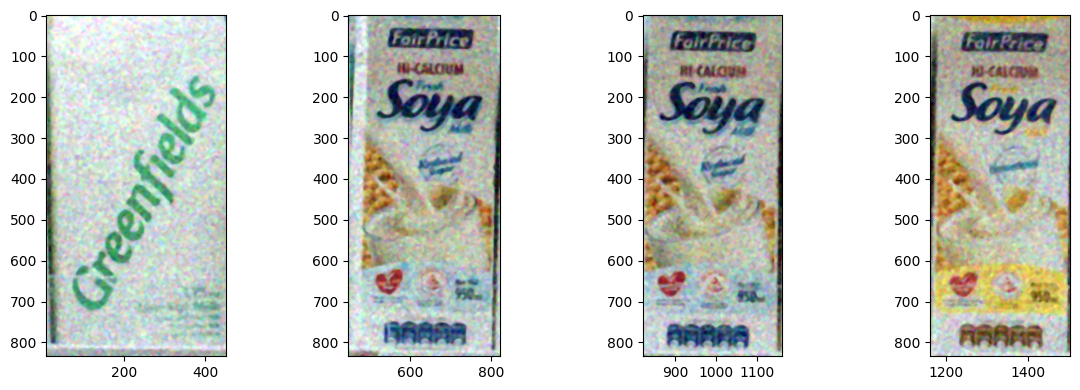

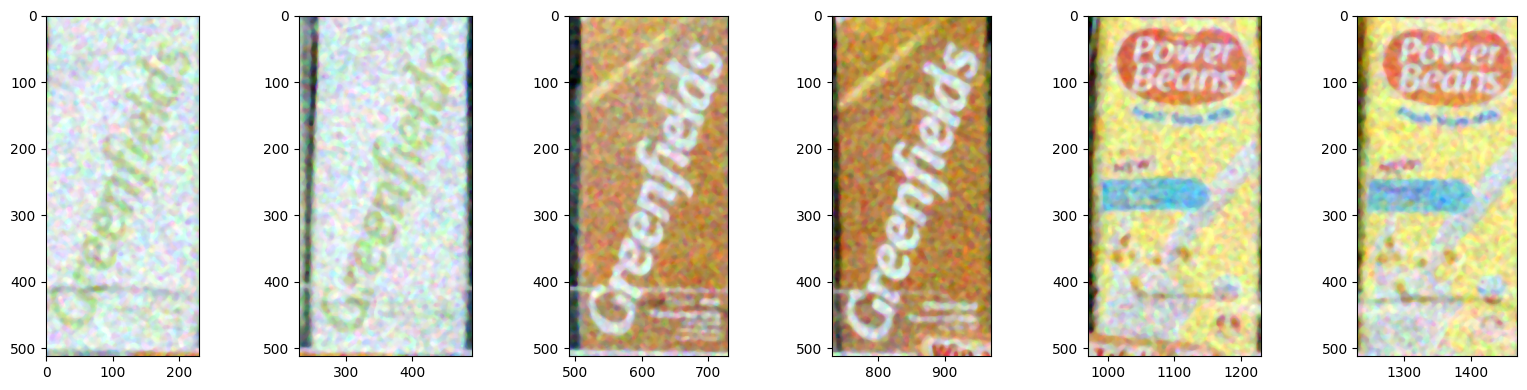

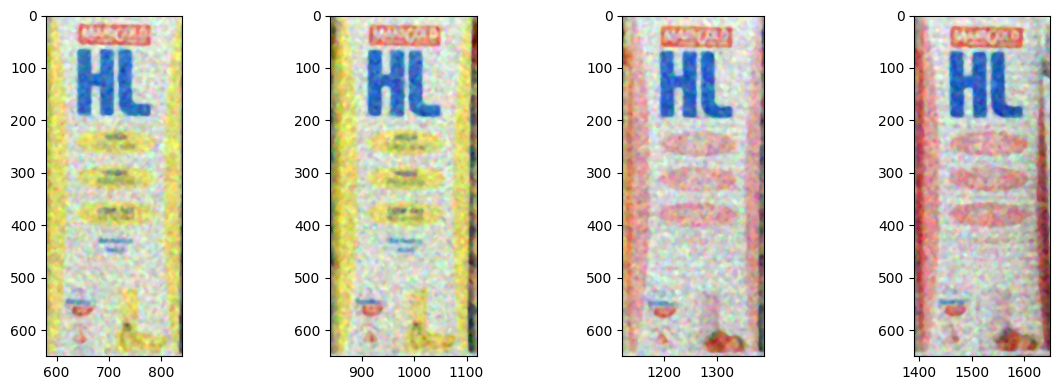

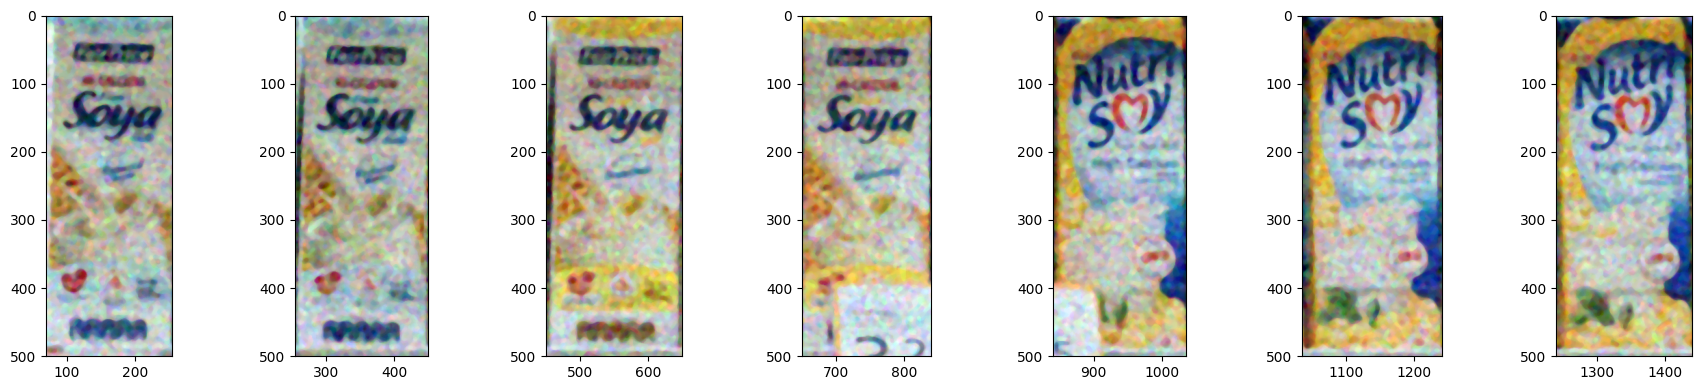

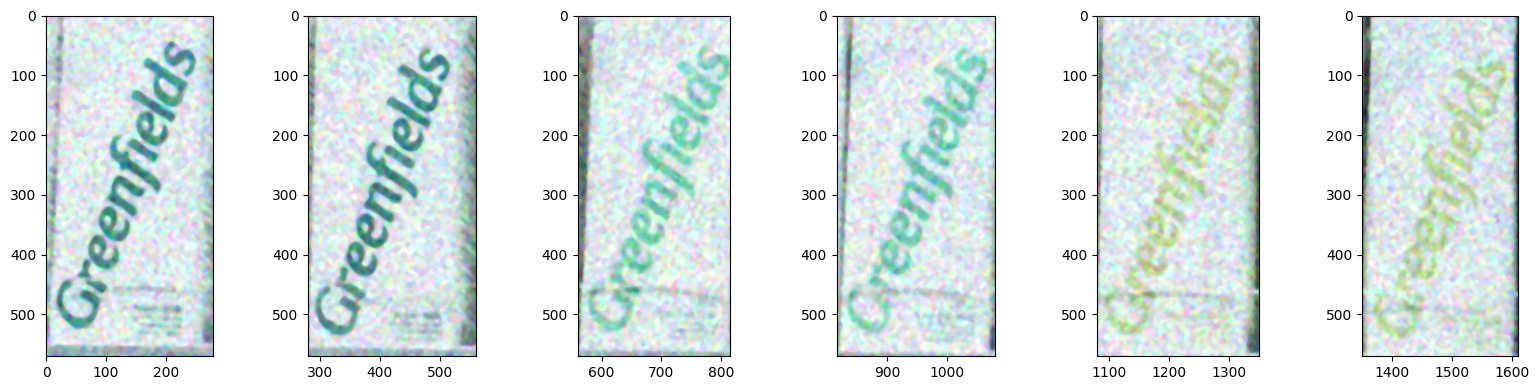

In [475]:
scene_images={}
for scene in positions:
    fig, axes = plt.subplots(1, len(positions[scene]['c'])-1, figsize=(2+2*len(positions[scene]['c']), 4),squeeze=False)
    axes = axes.flatten()

    image=cv2.imread(scenes_B[scene])
    image=denoise_image(image,filters)
    image=normalize2(image)
    l=positions[scene]['c'][0]
    r1,r2=positions[scene]['r']
    scene_images[scene]={}
    for i,r in enumerate(positions[scene]['c'][1:]):
        scene_images[scene][i]=image[r1:r2,l:r].copy()
        axes[i].imshow(image[r1:r2,l:r,::-1],extent=[l,r,r2-r1,0],aspect='equal')
        l=r

    plt.tight_layout()
    plt.show()

210.1796416202379
209.48583604536674
214.17006802721087
216.64173082742158
214.42672897824698
214.1064093512199


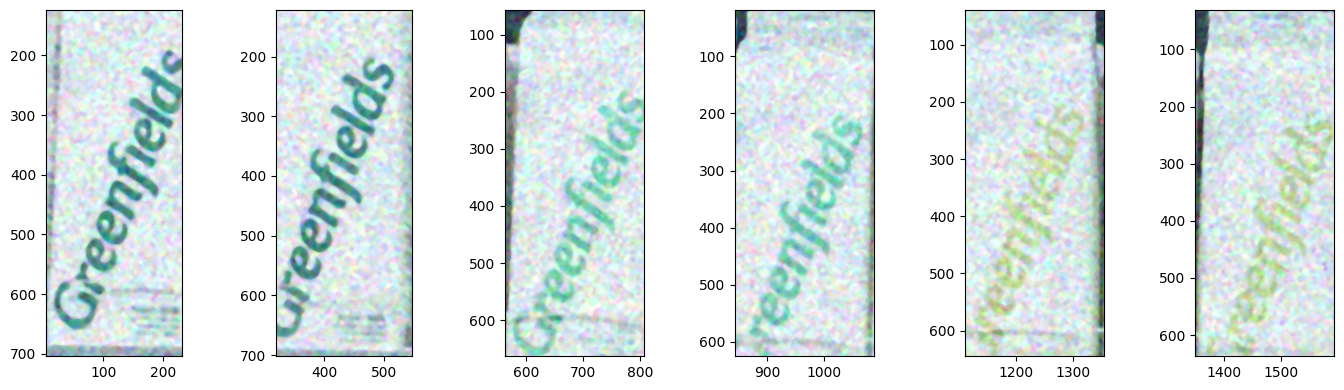

In [489]:
scene_images2={}
for scene in positions2:
    fig, axes = plt.subplots(1, len(positions2[scene]['c']), figsize=(2+2*len(positions2[scene]['c']), 4),squeeze=False)
    axes = axes.flatten()

    image=cv2.imread(scenes_B[scene])
    image=denoise_image(image,filters)
    image=normalize2(image)
    scene_images2[scene]={}
    for i in range(len(positions2[scene]['c'])):
        u,d=positions2[scene]['r'][i]
        l,r=positions2[scene]['c'][i]
        print(np.mean(image[u:d+1,l:r+1]))
        scene_images2[scene][i]=image[u:d+1,l:r+1]
        axes[i].imshow(image[u:d,l:r,::-1],extent=[l,r,d,u],aspect='equal')

    plt.tight_layout()
    plt.show()

In [477]:
def disturb_image(product,value,type):
    noise=0
    match type:
        case 'randint':
            noise=np.random.randint(-value,value,product_images[product].shape)+value
        case 'normal':
            noise=np.random.normal(scale=value,size=product_images[product].shape)
        case _: 
            return product_images[product]
    return np.clip(product_images[product]-noise,0,225).astype(np.uint8)

In [478]:
def compute_color_similarity(ref, scene):
    sceneR=scene[:,:,0]
    sceneG=scene[:,:,1]
    sceneB=scene[:,:,2]
    sceneR = cv2.resize(sceneR,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    sceneG = cv2.resize(sceneG,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    sceneB = cv2.resize(sceneB,(ref.shape[1],ref.shape[0]),None, cv2.INTER_LINEAR)
    scene=np.stack((sceneR,sceneG,sceneB),axis=-1)
    pixel_euclidean = np.linalg.norm(ref - scene)
    pixel_manhattan = np.sum(np.abs(ref - scene))
    pixel_cosine = np.dot(ref.flatten(), scene.flatten()) / (np.linalg.norm(ref) * np.linalg.norm(scene))
    
    # Compute histogram comparison metrics
    hist1 = cv2.calcHist([ref], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([scene], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    hist_intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    hist_chi_squared = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    hist_bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    
    return pixel_euclidean,pixel_manhattan,pixel_cosine,hist_intersection,hist_chi_squared,hist_bhattacharyya

In [479]:
VALUE=75
res={}
for scene in scene_images:
    res[scene]={}
    for i,slice in enumerate(scene_images[scene]):
        res[scene][i]={}
        # print(scene_images[scene][slice].shape)
        # mean_slice=np.mean(scene_images[scene][slice])
        for product in checks[scene][i]:
            scn=scene_images[scene][i]
            prod=product_images[product] #da ridimensionare
            # prod=cv2.resize(prod,(scn.shape[1],scn.shape[0]),interpolation=1)
            res[scene][i][product]=compute_color_similarity(prod,scn)


In [480]:
display(res)

{8: {0: {18: (158811.9999559227,
    130539266,
    2.5935781059709795e-09,
    106547.0,
    78988975.34923892,
    0.750340125786797),
   26: (142318.07213421632,
    111846426,
    1.8899707290708123e-09,
    76388.0,
    38438439.850708514,
    0.7574427602015316),
   27: (148950.14985558088,
    120231716,
    1.048509877826606e-10,
    106230.0,
    37675417.91170108,
    0.7225750490611461)},
  1: {17: (145471.08048337305,
    106537371,
    1.0101109561843043e-08,
    133304.0,
    2884644.7422829075,
    0.5105182196761727),
   23: (166437.81862305212,
    139256046,
    8.688213492912005e-09,
    163514.0,
    8364609.446488709,
    0.5269490572145475),
   24: (152384.9885881152,
    122632909,
    2.7042250775287957e-09,
    127788.0,
    17245826.972635105,
    0.6185412378554228)},
  2: {17: (138894.9580078413,
    96760368,
    8.109382851136725e-09,
    132391.0,
    2206532.584405285,
    0.5049347295481238),
   23: (160333.39527372332,
    128858550,
    6.180111758282

In [481]:
VALUE=75
res2={}
for scene in scene_images2:
    res2[scene]={}
    for i,slice in enumerate(scene_images2[scene]):
        res2[scene][i]={}
        for product in checks[scene][i]:
            scn=scene_images2[scene][i]
            prod=product_images[product]
            res2[scene][i][product]=compute_color_similarity(prod,scn)

In [482]:
display(res2)

{12: {0: {18: (200143.2027424364,
    185737072,
    3.876487588795604e-10,
    101808.0,
    410581622.91722876,
    0.7392374585370242)},
  1: {18: (193976.93193006224,
    177119025,
    2.103529643553042e-09,
    104649.0,
    282895129.211517,
    0.73598891312899)},
  2: {18: (202859.84595528018,
    188437461,
    3.4350984394909795e-09,
    100398.0,
    480653287.686628,
    0.7451446482835915)},
  3: {18: (200317.50048360726,
    183027862,
    2.609324415439153e-09,
    108433.0,
    359267382.2341623,
    0.7352111302439942)},
  4: {18: (196938.19739451256,
    177288537,
    1.1036062670701097e-09,
    122417.0,
    332310762.3711886,
    0.7037779076218618)},
  5: {18: (195424.15701238165,
    175879648,
    3.4836361118972835e-09,
    130711.0,
    268954903.2219449,
    0.6918273383359836)}}}

In [483]:
metrics=[*range(6)] # da 0 a 5
names={
0:'pixel_euclidean',
1:'pixel_manhattan',
2:'pixel_cosine',
3:'hist_intersection',
4:'hist_chi_squared',
5:'hist_bhattacharyya'}
for scene in res2:
    print(f'scene {scene}:')
    for slice in res2[scene]:
        print(f'\tslice {slice} (true:{true[scene][slice]}):')
        for i in metrics:
            vals=[res2[scene][slice][product][i] for product in res2[scene][slice]]
            max_value = max(vals)
            max_index = vals.index(max_value)
            keys=list(res2[scene][slice].keys())
            print(f'\t\tmetric {names[i]}, prod found: {keys[max_index]} ({max_value})')


scene 12:
	slice 0 (true:26):
		metric pixel_euclidean, prod found: 18 (200143.2027424364)
		metric pixel_manhattan, prod found: 18 (185737072)
		metric pixel_cosine, prod found: 18 (3.876487588795604e-10)
		metric hist_intersection, prod found: 18 (101808.0)
		metric hist_chi_squared, prod found: 18 (410581622.91722876)
		metric hist_bhattacharyya, prod found: 18 (0.7392374585370242)
	slice 1 (true:26):
		metric pixel_euclidean, prod found: 18 (193976.93193006224)
		metric pixel_manhattan, prod found: 18 (177119025)
		metric pixel_cosine, prod found: 18 (2.103529643553042e-09)
		metric hist_intersection, prod found: 18 (104649.0)
		metric hist_chi_squared, prod found: 18 (282895129.211517)
		metric hist_bhattacharyya, prod found: 18 (0.73598891312899)
	slice 2 (true:27):
		metric pixel_euclidean, prod found: 18 (202859.84595528018)
		metric pixel_manhattan, prod found: 18 (188437461)
		metric pixel_cosine, prod found: 18 (3.4350984394909795e-09)
		metric hist_intersection, prod found:

In [486]:
metrics=[3] # da 0 a 5
display(filters)
for scene in res2:
    print(f'scene {scene} {[e for e in true[scene].values()]}:')
    for i in metrics:
        print(f'\tmetric {names[i]}:')
        for slice in res2[scene]:
            vals=[res2[scene][slice][product][i] for product in res2[scene][slice]]
            max_value = max(vals)
            max_index = vals.index(max_value)
            keys=list(res2[scene][slice].keys())
            print(f'\t\tinstance_{slice}, prod found: {keys[max_index]} ({max_value})')


[{'name': 'median', 'n_iter': 1, 'params': {'ksize': 3}},
 {'name': 'median', 'n_iter': 0, 'params': {'ksize': 5}},
 {'name': 'median', 'n_iter': 2, 'params': {'ksize': 7}}]

scene 12 [26, 26, 27, 27, 18, 18]:
	metric hist_intersection:
		instance_0, prod found: 18 (101808.0)
		instance_1, prod found: 18 (104649.0)
		instance_2, prod found: 18 (100398.0)
		instance_3, prod found: 18 (108433.0)
		instance_4, prod found: 18 (122417.0)
		instance_5, prod found: 18 (130711.0)


In [485]:
# def check_smallest(res):
#     for scene in res:
#         print(f'scene {scene}')
#         for index, data in res[scene].items():
#             smallest_key = min(data.keys(), key=lambda k: data[k])
#             print(f"product {index+1}, best color: {smallest_key} ({res[scene][index][smallest_key]:.3f})")

# check_smallest(res)